# QUESTION 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### DEFINING FUNCTIONS

#### INTEGRAL IMAGE

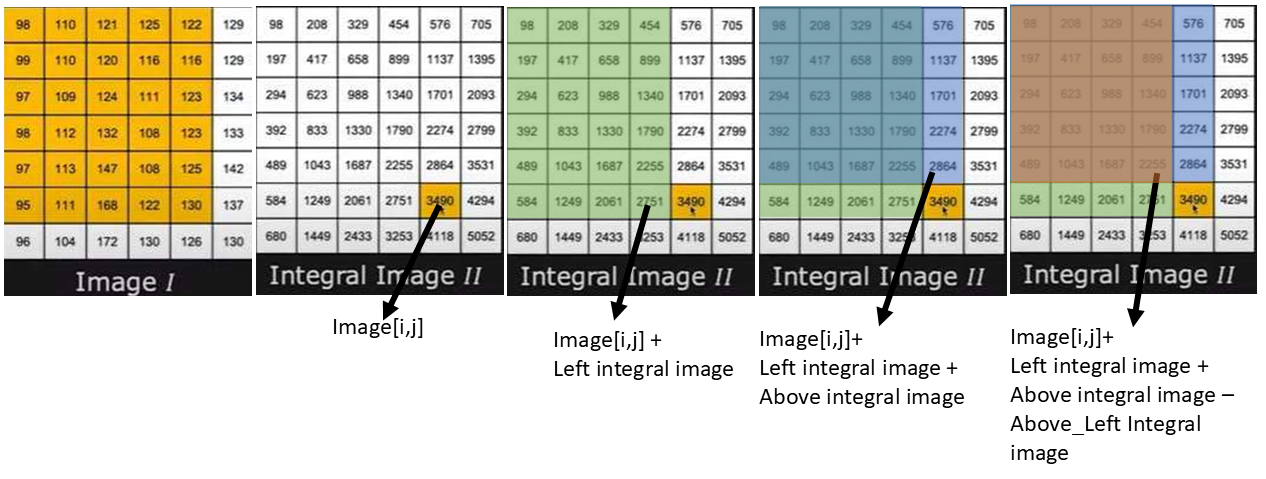


In [3]:
def integral_image(image): 

# The shape of image stored in (h,w) variable and should be grayscale
    h, w = image.shape  

    ii = np.zeros((h, w), dtype=np.int32)  #initializing the integral image as zero, of the size same as that of the initial image.
    
    # Loop through the integral image
    for i in range(h):  #Looping through the height
        for j in range(w):  #Looping through the width
            
#Store the value of integral image in the pixel above the current pixel. Store 0 if the pixel is along the top boundary.
            above = ii[i-1, j] if i > 0 else 0  

#Store the value of integral image in the pixel to the left of the current pixel. Store 0 if the pixel is along the left boundary.
            left = ii[i, j-1] if j > 0 else 0

# Store the value of integral image along the left diagnol. Store 0 is the pixel is on the top left corner.
            above_left = ii[i-1, j-1] if i > 0 and j > 0 else 0

#Calculating the value of integral image.
            ii[i, j] = image[i, j] + above + left - above_left

# Returning the integral image
    return ii 


#### HARR FEATURES

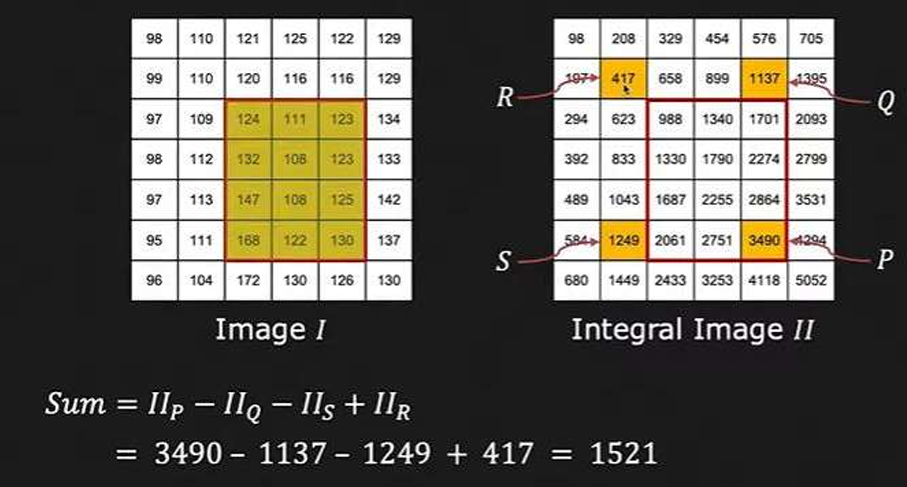

In [4]:
def sum_of_rectangle(ii, P, Q, S, R):
    
    (h,w) = ii.shape

    # Extract coordinates from the points
    xP, yP = P  # Bottom-right corner (P)
    xQ, yQ = Q  # Top-right corner (Q)
    xS, yS = S  # Bottom-left corner (S)
    xR, yR = R  # Top-left corner (R)
    total_sum = 0 # Sum of the rectangle PQRS

    # Sum of pixels in the rectangle using integral image formula
    if 0 <= xP < w and 0 <= yP < h:
        total_sum += ii[yP, xP]    #SUM = II_P

    if 0 <= xQ < w and 0 <= yQ < h:  #SUM = II_P - II_Q
        total_sum -= ii[yQ, xQ]

    if 0 <= xS < w and 0 <= yS < h:  #SUM = II_P - II_Q - II_S
        total_sum -= ii[yS, xS]

    if 0 <= xR < w and 0 <= yR < h:  #SUM = II_P - II_Q - II_S + I_R
        total_sum += ii[yR, xR]

    return total_sum #Return the sum of pixels in the rectangle.

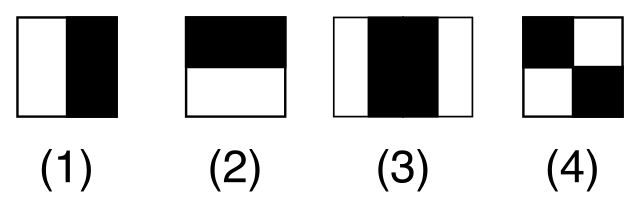

In [5]:
def sum_region(x,y, width, height,ii):

    '''
    (x,y) is the top left coordinate for that rectangle
    height and width here is for the harr-feature and the height and width divided by 2 (for (1), (2), (4)) and diveded by 3 for (3)
    '''
    
    (h,w) = ii.shape
    
    #BOUNDARY CONDITIONS
    if x < 0 or y < 0 or x + width > w or y + height > h:
        return 0  # Return 0 if the region is out of bounds
    
    
    P = (x + width - 1, y + height - 1)  # Bottom-right of rectangle
    S = (x - 1, y + height - 1)          # Bottom-left of rectangle 
    Q = (x + width - 1, y - 1)           # Top-right of rectangle 
    R = (x - 1, y - 1)                   #Top-left of recthangle 
    return sum_of_rectangle(ii, P, Q, S, R)

In [6]:
# HARR FEATURE: (1)[vertical= True] and (2)[vertical = False]
def haar_two_rectangle(ii, top_left, width, height, vertical=True):

    # Coordinates of the top-left corner of the entire rectangle
    (x, y) = top_left
    width_by_2 = width // 2
    height_by_2 = height//2
    
    # For vertical harr feature (1)
    if vertical:
        #for white region
        white = sum_region(x,y,width_by_2, height, ii)
        #for black region, the top left coordinate changes to x+width_by_2,y.
        black = sum_region(x+width_by_2, y, width_by_2, height, ii)

    else:
        black = sum_region(x,y,width, height_by_2, ii)
        #for white region, the top left corner changes to x,y+height_by_2.
        white = sum_region(x, y+ height_by_2, width, height_by_2, ii)

    # Return the difference between the black and white regions
    return (white - black)


In [7]:
# Three-rectangle Haar-like feature (Line feature) (3)
def haar_three_rectangle(ii, top_left, width, height):

    (x,y) = top_left  # Top-left corner of the entire region
    width_by_3 = width//3
    
# Sum of the first white rectangle
    white_1 = sum_region(x,y,width_by_3, height, ii)
#Sum of the black region in the middle
    black = sum_region(x+width_by_3, y, width_by_3, height, ii)
# Sum of second white rectangle
    white_2 = sum_region(x + 2*width_by_3,y, width_by_3, height ,ii)
# Return the difference between the sum of black and white regions
    return white_1 + white_2 - black 


In [8]:
# Four-rectangle Haar-like feature (4)
def haar_four_rectangle(ii, top_left, width, height):
    width_by_2 = width // 2
    height_by_2 = height // 2

    (x,y) = top_left  # Top-left corner of the entire region

 #Black 1 at the top left
    black1 = sum_region(x,y, width_by_2, height_by_2, ii)

#Black 2 at bottom right
    black2 = sum_region(x + width_by_2, y + height_by_2, width_by_2, height_by_2, ii)

#White 1 at the top right
    white1 = sum_region(x + width_by_2, y,  width_by_2, height_by_2, ii)

#White2 at the bottom left
    white2 = sum_region(x, y + height_by_2 , width_by_2, height_by_2, ii)
    
# Return the difference between the sum of black and white regions   
    return white1 + white2 - black1 - black2

In [9]:
'''
Function to generate a series of overlapping windows from the input image by sliding
a window of size = window_size across the image at stride = stride
'''

def sliding_window(ii, stride, window_size):
    (h, w) = ii.shape  # Image height and width
    (ww, wh) = window_size  # Window height and width
    for y in range(0, h - wh + 1, stride):  
        for x in range(0, w - ww + 1, stride):  
            yield (x, y, ii[y:y + wh, x:x + ww])  # Extract window from the image
            # (x, y) is the top-left position of the window


In [10]:
def extract_haar_features(window, top_left, window_size):
    features = []
    (ww, wh) = window_size
    f1 = haar_two_rectangle(window, top_left, ww, wh, vertical=True)
    f2 = haar_two_rectangle(window, top_left, ww, wh, vertical=False)
    f3 = haar_three_rectangle(window, top_left, ww, wh)
    f4 = haar_four_rectangle(window, top_left, ww, wh)

    # Append the feature dictionary directly
    features.append({
                    "Haar Feature 1": f1,
                    "Haar Feature 2": f2,
                    "Haar Feature 3": f3, 
                     "Haar Feature 4": f4
                     })
    
    return features  # This returns a list with one dictionary


In [11]:
def extract_features_from_sliding_window(ii, stride, window_size):
 # Function to extract Haar features from each window generated by the sliding window function and store it's average to a list

    features = []
    for (x, y, window) in sliding_window(ii, stride, window_size):
        # Extract features for the current window
        top_left = (x,y)
        feature_values = extract_haar_features(window,top_left, window_size)
        features.append((feature_values[0], (x, y)))

    return features




In [12]:
def classify_faces(features, lower_thresh, upper_thresh):
    """Filter windows based on the thresholds."""

    potential_faces = []
    (ww, wh) = window_size

    for feature_values, (x, y) in features:
        # Access Haar features directly
        f1 = feature_values["Haar Feature 1"]
        f2 = feature_values["Haar Feature 2"]
        f3 = feature_values["Haar Feature 3"]
        f4 = feature_values["Haar Feature 4"]


        # Apply thresholding for each Haar feature
        if (lower_thresh[0] < f1 < upper_thresh[0]and
            lower_thresh[1] < f2 < upper_thresh[1] and
            lower_thresh[2] < f3 < upper_thresh[2] and
            lower_thresh[3] < f4 < upper_thresh[3]):
            
            potential_faces.append((x, y, ww, wh))

    return potential_faces

In [13]:
def draw_rectangles(image, detections):
    # Convert the grayscale image to RGB format (3 channels)
    output_image = np.stack([image, image, image], axis=-1)

    # Iterate over each detection and draw a red rectangle
    for (x, y, w, h) in detections:
        # Draw a rectangle by setting the red channel to maximum value (255) and green, blue to 0
        output_image[y, x:x + w, 0] = 255  # Top edge (Red channel)
        output_image[y + h - 1, x:x + w, 0] = 255  # Bottom edge (Red channel)
        output_image[y:y + h, x, 0] = 255  # Left edge (Red channel)
        output_image[y:y + h, x + w - 1, 0] = 255  # Right edge (Red channel)
        
        # Set green and blue channels to 0 to ensure red color
        output_image[y, x:x + w, 1:3] = 0  # Top edge (Green, Blue channels)
        output_image[y + h - 1, x:x + w, 1:3] = 0  # Bottom edge (Green, Blue channels)
        output_image[y:y + h, x, 1:3] = 0  # Left edge (Green, Blue channels)
        output_image[y:y + h, x + w - 1, 1:3] = 0  # Right edge (Green, Blue channels)

    return output_image


#### IMPLEMENTATION

In [ ]:
image_rgb = Image.open(r'E:\codes\cv\A2\pictures\face-img2.jpg') 

image = image_rgb.convert('L')

plt.imshow(image, cmap='gray')
plt.title('Face Image')
plt.grid()
plt.xticks(np.arange(0, 251, 25))
plt.yticks(np.arange(0, 251, 25))
plt.show()

In [15]:
image_ndarray = np.asarray(image)

In [ ]:
plt.imshow(image_ndarray,cmap="gray")
plt.grid()
plt.xticks(np.arange(0, 251, 25))
plt.yticks(np.arange(0, 251, 25))
plt.show()

In [17]:
ii = integral_image(image_ndarray)

In [18]:
image_ndarray.shape

(250, 250)

In [19]:
ii.shape

(250, 250)

In [20]:
window_size = (100,100)
stride = 25

In [ ]:

lower_thresh = [0, -20, 0, 0]
upper_thresh = [3000000, 150000, 500000, 500000]

# Extract features and classify potential faces
features = extract_features_from_sliding_window(ii, stride, window_size)
potential_faces = classify_faces(features, lower_thresh, upper_thresh)

# Print out detected potential faces
print(f'Potential faces at: {potential_faces}')

# Draw rectangles on the original image
output_image = draw_rectangles(image, potential_faces)

# Show the output image with detected faces
plt.imshow(output_image, cmap='gray')
plt.title('Detected Faces')
plt.xticks(np.arange(0, 251, 25))
plt.yticks(np.arange(0, 251, 25))
plt.show()


# QUESTION 2

### Importing Libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

### Defining paths to the images

In [24]:
dataset_real = r'E:\codes\cv\A2\anti_face_spoof\real'
dataset_spoof = r'E:\codes\cv\A2\anti_face_spoof\spoof'

In [25]:
#Storing path of the real images to real_image_paths and path of spoofed images to spoof_image_paths.
real_image_paths = [os.path.join(dataset_real, img) for img in os.listdir(dataset_real) if img.endswith('.jpg') or img.endswith('.png')]
spoof_image_paths = [os.path.join(dataset_spoof, img) for img in os.listdir(dataset_spoof) if img.endswith('.jpg') or img.endswith('.png')]

### Visualizing the type of images

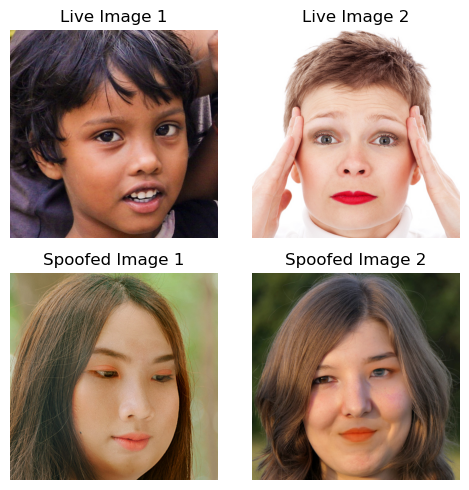

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))  # 2x2 grid

image1 = Image.open(real_image_paths[0])
image2 = Image.open(real_image_paths[1])
image3 = Image.open(spoof_image_paths[0])
image4 = Image.open(spoof_image_paths[2])

axs[0, 0].imshow(image1, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title('Live Image 1')

axs[0, 1].imshow(image2, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title('Live Image 2')

axs[1, 0].imshow(image3, cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Spoofed Image 1')

axs[1, 1].imshow(image4, cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Spoofed Image 2')


plt.tight_layout()  # Adjust layout
# plt.title('Example of Live and Spoofed Image')
plt.show()  # Display the images


### FUNCTION FOR RESIZING THE IMAGE


In [27]:
def resize_image(original, nw, nh):
#original must be np.ndarray
    (oh,ow) = original.shape
# Create a new image with the desired dimensions
    resized_image = np.zeros((nh,nw))

    for ny in range(nh):
        for nx in range(nw):
            #CORRESPONDING PIXEL IN ORIGINAL IMAGE
            ox = int(nx * ow / nw)
            oy = int(ny * oh / nh)
            resized_image[ny][nx] = original[oy][ox]
    
    return resized_image                                    

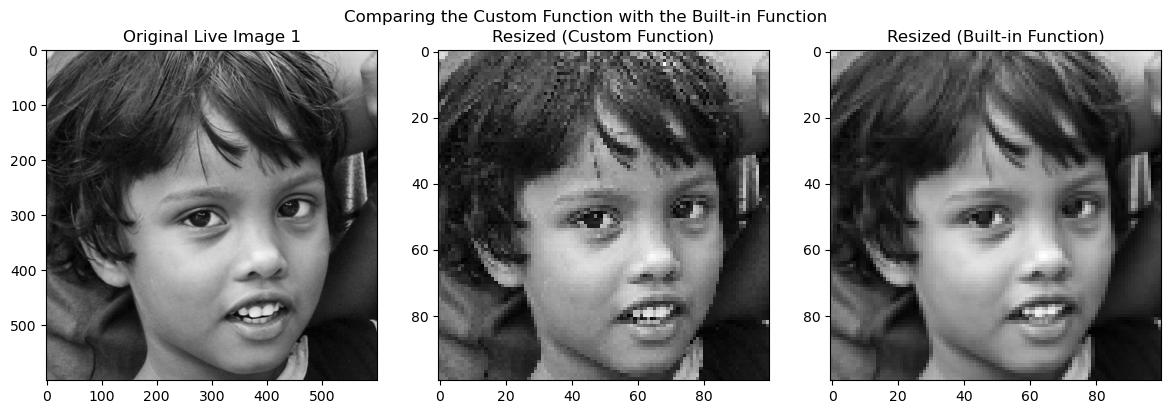

In [28]:
image1 = Image.open(real_image_paths[0]).convert('L')  
image_array = np.asarray(image1) 
# Resize using custom function
image2 = resize_image(image_array, 100, 100)
# Resize using built-in PIL function
image3 = image1.resize((100, 100)) 
# Plotting the images for comparison
fig, axs = plt.subplots(1, 3, figsize=(12, 4)) 

axs[0].imshow(image1, cmap='gray')
axs[0].set_title('Original Live Image 1')

axs[1].imshow(image2, cmap='gray')
axs[1].set_title('Resized (Custom Function)')

axs[2].imshow(image3, cmap='gray')
axs[2].set_title('Resized (Built-in Function)')

plt.suptitle("Comparing the Custom Function with the Built-in Function")
plt.tight_layout()  # Adjust layout
plt.show()  # Display the images

As we can see, the resize function works well

### Functions for calculating the metrics

In [29]:
#FUNCTION TO CREATE A CONFUSION MATRIX WITH RESPECT TO CLASSNUM

def confusion_matrix(y_true, y_pred,classnum): 

#INITIALIZING THE METRICS
    TP = 0  # TRUE POSITIVE
    FP = 0  # FALSE POSITIVE
    TN = 0  # TRUE NEGATIVE
    FN = 0  # FALSE NEGATIVE

    for true, pred in zip(y_true, y_pred): #LOOPING THROUGH THE TRUE AND PREDICTED VALUE OF THE VALIDATION SET

        if true == classnum and pred == classnum:   # CONDITION FOR TRUE POSITIVE
            TP += 1

        elif true != classnum and pred == classnum:  # CONDITION FOR FALSE POSITIVE
            FP += 1

        elif true != classnum and pred != classnum:   # CONDITION FOR TRUE NEGATIVE
            TN += 1
            
        elif true == classnum and pred != classnum:    # CONDITION FOR FALSE NEGATIVE
            FN += 1

    return TP, FP, TN, FN

In [30]:
# FUNCTION TO FIND ACCURACY W.R.T CLASSNUM
def find_accuracy(y_true, y_pred, classnum):

    TP, FP, TN, FN = confusion_matrix(y_true, y_pred,classnum) # GET THE VALUES FROM THE CONFUSION MATRIX
    
    if (TP + TN + FP + FN) == 0:    # CONDITION TO AVOID ERROR.
        return 0
    return (TP + TN) / (TP + TN + FP + FN)   # RETURN THE ACCURACY OF THE CLASS
    

In [31]:
def find_precision(y_true, y_pred,classnum):
    #FUNCTION TO FIND PRECISION W.R.T CLASSNUM
    
    TP, FP, _, _ = confusion_matrix(y_true, y_pred,classnum)   # GET THE VALUES FROM THE CONFUSION MATRIX
    if (TP + FP) == 0:     # CONDITION TO AVOID ERROR.
        return 0
    return TP / (TP + FP)   # RETURN THE PRECISION OF THE CLASS

In [32]:
def find_recall(y_true, y_pred,classnum):
    #FUNCTION TO FIND PRECISION W.R.T CLASSNUM
    TP, _,_, FN = confusion_matrix(y_true, y_pred,classnum)  # GET THE VALUES FROM THE CONFUSION MATRIX

    if (TP + FN) == 0:    # CONDITION TO AVOID ERROR.
        return 0
    return TP / (TP + FN)    # RETURN THE RECALL OF THE CLASS

In [33]:
def find_specificity(y_true, y_pred,classnum):
    #FUNCTION TO FIND SPECIFICITY W.R.T CLASSNUM
    _, FP, TN, _ = confusion_matrix(y_true, y_pred,classnum)   # GET THE VALUES FROM THE CONFUSION MATRIX

    if (TN + FP) == 0:    # CONDITION TO AVOID ERROR.
        return 0
    return TN / (TN + FP)    # RETURN THE SPECIFICITY OF THE CLASS

In [34]:
def f1_score(y_true, y_pred, classnum):

    #FUNCTION TO FIND THE F1-SCORE W.R.T CLASSNUM

    precision = find_precision(y_true, y_pred,classnum)   # GET THE PRECISION USING THE PREVIOUSLY DEFINED FUNCTION
    recall = find_recall(y_true, y_pred,classnum)         # GET THE RECALL USING THE PREVIOUSLY DEFINED FUNCTION

    if (precision + recall) == 0:   # CONDITION TO AVOID ERROR.
        return 0
    return 2 * (precision * recall) / (precision + recall)    # RETURN THE F1 SCORE OF CLASSNUM

In [35]:
# FUNCTION TO COLLECTIVELY SHOW EACH METRIC AND CONFUSION MATRIX THE CLASS.
def show_metrics(y_true, y_pred, classnum):   
    
    
    # GETTING ALL THE METRICS USING THE FUNCTIONS DEFINED EARLIER
    prec = find_precision(y_true, y_pred, classnum)
    rec = find_recall(y_true, y_pred, classnum)
    spec = find_specificity(y_true, y_pred, classnum)
    f1 = f1_score(y_true, y_pred, classnum)
    acc = find_accuracy(y_true, y_pred, classnum)

    # PRINTING ALL THE RESULTS UPTIO 2 DECIMAL PLACES
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"Specificity: {spec:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # GETTING THE CONFUSION MATRIX USING THE FUNCTIONO DEFINED EARLIER AND PRINTING IT.
    TP, FP, TN, FN = confusion_matrix(y_true, y_pred, classnum)
    class_labels = ['Real', 'Spoofed']

    # IF CLASSNUM = 1, I.E. CONFUSION MATRIX IS FOUND WRT TO SPOOF IMAGES, SWAP THE POSITION OF LABELS IN THE MATRIX.
    if classnum == 1:
        cm = np.array([[TP, FP], [FN, TN]])

    else:  
        cm = np.array([[TN, FN], [FP, TP]]) 

    # VISUALIZING THE CONFUSION MATRIX
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # DISPLAY THE METRICS IN THE CONFUSION MATRIX
    thresh = cm.max() / 2.0  # THRESHOLD FOR TEXT COLOR TO ENSURE THE TEXT IS VISIBLE.
    
    for i in range (0, cm.shape[0]):
        for j in range (0,cm.shape[1]): # LOOP OVER THE MATRIX
            plt.text(j, i, format(cm[i, j], 'd'),  # DISPLAY THE VALUES IN THE MATRIX
                 ha="center", va="center",         # SETTING THE HORIZONTAL AND VERTICAL ALIGNMENT OF THE TEXT
                 color="white" if cm[i, j] > thresh else "black")  # SETTING THE COLOR FOR VISUALIZATION

    plt.tight_layout()
    plt.show()

### Labelling the data

In [36]:
def label_images(real_image_paths, spoof_image_paths):   # TAKE IMAGE PATHS AS INPUT
    # LABELS: 0 FOR REAL IMAGES AND 1 FOR SPOOF IMAGES

    # DEFINING LISTS FOR STORING THE IMAGES AND CORRESPONDING LABELS
    images = []  
    labels = [] 

    # LABELLING REAL IMAGES
    for path in real_image_paths:
        img = Image.open(path).convert('L')      #LOAD AND CONVERT TO GRAYSCALE
        img_ndarray = np.asarray(img)            # CONVERT TO NDARRAY 
        img = resize_image(img_ndarray, 64, 64)  # RESIZE THE IMAGES FOR REDUCING THE COMPUTATION TIME
        images.append(img.flatten())             # FLATTENING THE DATA SINCE SVM WILL BE USED.
        labels.append(0)                        # APPEND TO LABEL: 0 SINCE THE REAL IMAGES ARE LABELLED ZERO (HERE)

    # LABELLING SPOOF IMAGES
    for path in spoof_image_paths:
        img = Image.open(path).convert('L')      #LOAD AND CONVERT TO GRAYSCALE
        img_nd = np.asarray(img)                # CONVERT TO NDARRAY 
        img = resize_image(img_nd, 64, 64)      # RESIZE THE IMAGES FOR REDUCING THE COMPUTATION TIME
        images.append(img.flatten())            # FLATTENING THE DATA SINCE SVM WILL BE USED.
        labels.append(1)                        # APPEND TO LABEL: 1 SINCE THE SPOOFED IMAGES ARE LABELLED ONE (HERE)

    return np.array(images), np.array(labels)    # RETURN IMAGES AND LABELS LIST AS NDARRAY

In [37]:
images, labels = label_images(real_image_paths, spoof_image_paths)  # CALLING THE PREVIOUS FUNCTION.
 
# images and labels STORE THE IMAGES IN NDARRAY FORM AND CORRESPONDING LABELS

In [38]:
# PRINTING THE LENGTHS OF BOTH THE ARRAYS
print(f"""The length of images array is: {len(images)}
The length of labels array is: {len(labels)}""")

The length of images array is: 2041
The length of labels array is: 2041


In [39]:
# FUNCTION TO CLASSIFY, PREDICT AND SHOW THE METRICS

# INPUT X,y ARE THE IMAGES AND IT'S LABEL.
# CLASSNUM TAKEN FOR FINDING THE METRICS LATER.

def classify(X, y, classnum):
    # SPLITTING THE DATA TO TRAIN AND TEST
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # USING SUPPORT VECTOR CLASSIFIER. RANDOM_STATE DEFINED TO ENSURE SAME RESULT IN EACH RUN.
    clf = SVC(random_state=42)

    # FITTING THE CLASSIFIER WITH TRAINING DATA
    clf.fit(X_train, y_train)

    # PREDICTING THE VALUES FROM TEST DATA
    y_pred = clf.predict(X_test)

    # SHOW THE METRICS OF THE CLASSIFIER
    show_metrics(y_test, y_pred, classnum)
    
    # RETURN THE CLASSIFIER
    return clf

### QUESTION 2(A)

#### TRAINING SVM IN RAW PIXEL FEATURES

Accuracy: 0.62
Precision: 0.61
Recall: 0.53
Specificity: 0.70
F1-Score: 0.57


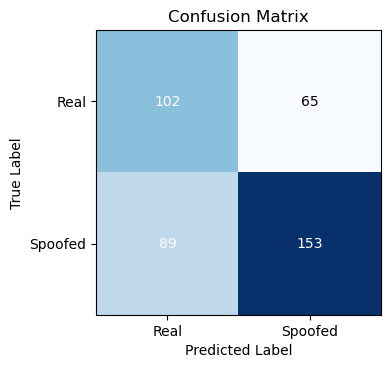

In [40]:
clf1 = classify(images, labels, 1)

### QUESTION 2(B)

In [41]:
# FUNCTION TO DO PADDING
# THIS FUNCTION CAN DO TWO TYPES OF PADDING: ZERO PADDING AND REPLICATE PADDING

def pad(image, pad_width, t = 'z'):
    
    # t CAN TAKE TWO VALUES 'z' AND 'r' FOR DOING ZERO AND REPLICATE PADDING RESPECTIVELY. DEFAULT IS ZERO PADDING.
    
    (oh, ow) = image.shape  # STORING THE ORIGINAL IMAGE SHAPE
    
    # DEFINING THE SHAPE OF PADDED IMAGE
    ph = oh + 2 * pad_width
    pw = ow + 2 * pad_width
    
    # INTIALIZE THE PADDED IMAGE WITH ALL ZERO VALUES
    padded_image = np.zeros((ph, pw))
    
    # PLACE THE ORIGINAL IMAGE ON TOP OF THE PADDED IMAGE USING SLICING OF ARRAY
    padded_image[pad_width:pad_width + oh, pad_width:pad_width + ow] = image
    
    if t == 'r':
        # REPLICATE PADDING

        # REPLICATE THE TOP AND BOTTOM ROWS
        padded_image[:pad_width, pad_width:pad_width + ow] = image[0, :]            # TOP PADDING

        padded_image[pad_width + oh:, pad_width:pad_width + ow] = image[-1, :]      # BOTTOM PADDING

        # REPLICATING THE LEFT AND RIGHT COLUMNS
        padded_image[:, :pad_width] = padded_image[:, pad_width:pad_width + 1]      # LEFT PADDING

        padded_image[:, pad_width + ow:] = padded_image[:, pad_width + ow - 1:pad_width + ow]  # RIGHT PADDING

    return padded_image


#### TRAINING SVM ON LBP FEATURES

In [42]:
# FUNCTION TO EXTRACT LBP FEATURE FOR EACH PIXEL VALUE AND RETURN A LBP HISTOGRAM

def lbp_value(image):  #image IS IN GRAYSCALE AND AS NDARRAY

    (h,w) = image.shape
    
    image = pad(image, 1, 'r')   # PERFORM REPLICATE PADDING TO THE IMAGE

    lbp_image = np.zeros((h - 2, w - 2))   # INTIALIZE THE LBP IMAGE. 
    
    # COMPUTE LBP FOR EACH PIXEL
    for i in range(1, h - 1): # IGNORE THE BOUNDARY VALUES WHILE LOOPING. -1 SINCE I AM CONSIDERING LBP WITH 3 NEIGHBOURS
        for j in range(1, w - 1):
            center_pixel = image[i, j]  
            binary_num = ''
            
            # CLOCKWISE ROTATION FOR NEIGHBOURHOOD

            neighborhood = [
                image[i-1, j-1], image[i-1, j], image[i-1, j+1],
                image[i, j+1], image[i+1, j+1], image[i+1, j],
                image[i+1, j-1], image[i, j-1]
            ]
            
            # BINARY NUM: 
            for neighbor in neighborhood:
                binary_num += '1' if neighbor >= center_pixel else '0'
            
            # CONVERT BINARY TO DECIMAL
            lbp_num = int(binary_num, 2)

            # STORING IN LBP IMAGE
            lbp_image[i-1, j-1] = lbp_num
    
    # CALCULATE LBP PATTERN
    lbp_histogram, _ = np.histogram(lbp_image, bins=np.arange(257), density=True)
    return lbp_histogram

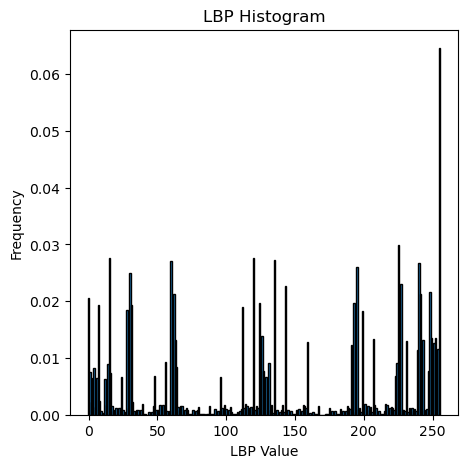

In [43]:
# CHECKING LBP VALUE OF AN IMAGE
lbp_histogram = lbp_value(np.asarray(image1))  # Assuming grayscale_image is your input image

# Plot the LBP histogram
plt.figure(figsize=(5,5))
plt.bar(range(256), lbp_histogram, width=1, edgecolor='black')
plt.title('LBP Histogram')
plt.xlabel('LBP Value')
plt.ylabel('Frequency')
plt.show()

In [44]:
# FUNCTION TO EXTRACT LBP FEATURES FOR A LIST OF IMAGES AND RETURN FEATURE VECTORS WITH CORRESPONDING LABELS

def extract_lbp_features(image_paths, label):

    feature_vector = []
    labels = []
    
    for path in image_paths:
        
        img = Image.open(path).convert('L') # LOAD AND CONVERT TO GRAYSCALE
        img_ndarray = np.asarray(img)
        img_resized = resize_image(img_ndarray, 64, 64)  # RESIZING THE IMAGE
        lbp_features = lbp_value(img_resized)  # EXTRACT LBP FEATURES
        feature_vector.append(lbp_features)  # APPEND LBP FEATURES
        labels.append(label)  # APPEND CORRESPONDING LABELS
    
    return feature_vector, labels

In [45]:
# EXTRACT LBP FEATURES OF LIVE AND SPOOF IMAGES

real_lbp, real_label = extract_lbp_features(real_image_paths, 0)  # 0 for live
spoof_lbp, spoof_label = extract_lbp_features(spoof_image_paths, 1)  # 1 for spoof

# COMBINE BOTH LBP FEATURES AND LABELS INTO SINGLE VECTORS
X = np.array(real_lbp + spoof_lbp)
y = np.array(real_label+ spoof_label)

Accuracy: 0.53
Precision: 0.54
Recall: 0.94
Specificity: 0.07
F1-Score: 0.68


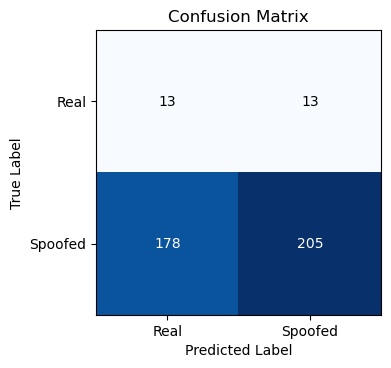

In [46]:
clf2 = classify(X,y, 0)

### QUESTION 2(C)

In [47]:
def conv(filter_matrix,img_ndarray):
    filter_size = filter_matrix.shape[0]  
    pad_size = ((filter_size)-1)//2  #Calculating the padding 
    padded_img = pad(img_ndarray,pad_size, t='z')  #performing zero padding
    conv_img = np.zeros(img_ndarray.shape)    #array of zeros of size of original image
    for i in range(pad_size,padded_img.shape[0]-pad_size):  #Loop for height
        for j in range(pad_size,padded_img.shape[1]-pad_size):  #Loop for width
            g = padded_img[i-pad_size:i+pad_size+1,j-pad_size:j+pad_size+1]  # Extracting the Region to be convoluted by filter
            h = np.sum(filter_matrix * g)  #Performing convolution
            conv_img[i-pad_size][j-pad_size] = h   #adding the pixel value to the result image

    return conv_img   #returning the result image.

In [48]:
def grad_magnitude(x, y):
    return np.sqrt(x**2 + y**2)

In [49]:
def edge_detector(image, d):
# d = 'p' for prewitts edge detector and d = 's' for sobel edge detector

    if d == 'p': #prewitt's edge detector 
        x = np.array([[ -1,  0,  1],
                              [ -1,  0,  1],
                              [ -1,  0,  1]])

        y = np.array([[ -1, -1, -1],
                              [  0,  0,  0],
                              [  1,  1,  1]])
    
    elif d == 's':  #sobel edge detector
        x = np.array([[ -1,  0,  1],
                        [ -2,  0,  2],
                        [ -1,  0,  1]])

        y = np.array([[ -1, -2, -1],
                        [  0,  0,  0],
                        [  1,  2,  1]])


    return grad_magnitude (conv(x, image), conv(y, image) )


In [50]:
def extract_edge_features(image_paths, label, d):
    feature_vectors = []
    labels = []
    
    for path in image_paths:
        img = Image.open(path).convert('L')  # Load and convert to grayscale
        img_ndarray = np.asarray(img)        # Convert to numpy array
        img_resized = resize_image(img_ndarray, 64, 64)  # Resize image
        
        # Perform edge detection using the provided detector_type ('p' or 's')
        edge_img = edge_detector(img_resized, d)  
        
        # Flatten the edge image to create a feature vector
        feature_vector = edge_img.flatten()  # Flatten into 1D array
        
        feature_vectors.append(feature_vector)  # Append the feature vector
        labels.append(label)  # Append corresponding label (live/spoof)
    
    return feature_vectors, labels


### SOBEL EDGE

In [51]:
# EXTRACT LBP FEATURES OF LIVE AND SPOOF IMAGES
real_sobel, real_sobel_label = extract_edge_features(real_image_paths, 0, 's')  # 0 for live
spoof_sobel, spoof_sobel_label = extract_edge_features(spoof_image_paths, 1, 's')  # 1 for spoof

# COMBINE BOTH LBP FEATURES AND LABELS INTO SINGLE VECTORS
X_sobel = np.array(real_sobel + spoof_sobel)
y_sobel = np.array(real_sobel_label+ spoof_sobel_label)

Accuracy: 0.63
Precision: 0.62
Recall: 0.77
Specificity: 0.47
F1-Score: 0.69


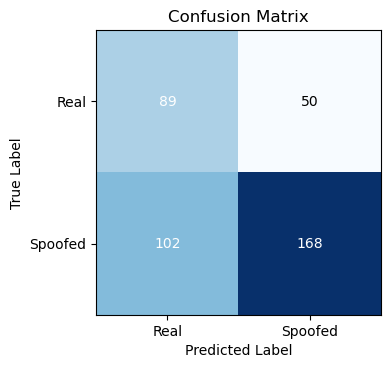

In [53]:
clf_sobel = classify(X_sobel, y_sobel, 0)                                  

### PREWITT EDGE

In [43]:
# EXTRACT LBP FEATURES OF LIVE AND SPOOF IMAGES
real_prewitt, real_prewitt_label = extract_edge_features(real_image_paths, 0, 'p')  # 0 for live
spoof_prewitt, spoof_prewitt_label = extract_edge_features(spoof_image_paths, 1, 'p')  # 1 for spoof

# COMBINE BOTH LBP FEATURES AND LABELS INTO SINGLE VECTORS
X_prewitt = np.array(real_prewitt + spoof_prewitt)
y_prewitt = np.array(real_prewitt_label+ spoof_prewitt_label)

Accuracy: 0.63
Precision: 0.62
Recall: 0.77
Specificity: 0.46
F1-Score: 0.69


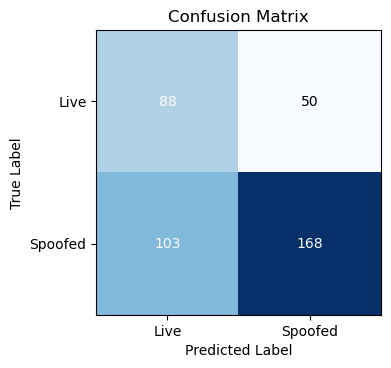

SVC(random_state=42)

In [44]:
clf_prewitt = classify(X_prewitt, y_prewitt, 0)